In [1]:
DO_ALL = True # 전체 실행하면서 시간 걸리는 걸 Pass 하려면 이걸 False ...
## print(f'\r{self.prefix} |{bar}| {percent}% {self.suffix}  {text}', end="", flush=True)

In [2]:
if DO_ALL:
    !pip install sentence-transformers==0.3.0
    !pip install transformers==3.0.2
    !pip install wikipedia
    !pip install konlpy

     |████████████████████████████████| 61 kB 299 kB/s eta 0:00:011
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.0-py3-none-any.whl size=86752 sha256=94bc612ffb3af36eada82e6b398100f1d095191dbc47f42fa149b1f7f1efd3ff
  Stored in directory: /root/.cache/pip/wheels/3e/15/94/49bc84289d2c77b5059bca513f840c6006d4e2cc7f10275d49
Successfully built sentence-transformers
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 769 kB 1.2 MB/s eta 0:00:01


     |████████████████████████████████| 3.0 MB 6.1 MB/s eta 0:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.9.3
    Uninstalling tokenizers-0.9.3:
      Successfully uninstalled tokenizers-0.9.3
  Attempting uninstall: transformers
    Found existing installation: transformers 3.5.1
    Uninstalling transformers-3.5.1:
      Successfully uninstalled transformers-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 1.2.2 requires transformers<3.6,>=3.4, but you have transformers 3.0.2 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11685 sha256=69afddf87ebc033b0be414a76fbc0074bc61c8a0f373be99372c166a59d28ba1
  Stored in directory: /root/.cache/pip/wheels/15/9

In [43]:
# keras module for building LSTM 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout,Conv1D, MaxPooling1D, Flatten
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from tensorflow.python.framework import tensor_shape
import keras.utils as ku 

# set seeds for reproducability
from tensorflow.random import set_seed
from numpy.random import seed
set_seed(2)
seed(1)

import pandas as pd
import numpy as np
import string, os 

import urllib.request
import nltk
nltk.download('punkt')

from konlpy.tag import Okt

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# 간단한 전처리
def clean_text(txt):
    txt = txt.replace('\n',' ')
    txt = txt.replace('\r',' ')    
    txt = txt.replace('=','')
    txt = txt.replace('\"','')   
    txt = txt.replace('\'','')
    txt = txt.replace(',','')
    txt = txt.replace('..','')
    txt = txt.replace('.','. ')
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')           
    return txt 

In [12]:
# load ascii text and covert to lowercase

def get_sample_text(target_url):
    raw_text = urllib.request.urlopen(target_url).read().decode('utf-8')
    return nltk.sent_tokenize(clean_text(raw_text))

In [103]:
ko_sentences_dataset = []

ko_sentences_dataset += get_sample_text("https://raw.githubusercontent.com/dolmani38/Summary/master/data/korean_sample.txt")
# 여기서 계속 수집...
ko_sentences_dataset += get_sample_text("https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-ABC%20%EC%82%B4%EC%9D%B8%EC%82%AC%EA%B1%B4.txt")

ko_sentences_dataset += get_sample_text("https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EA%B7%B8%EB%A6%AC%EA%B3%A0%20%EC%95%84%EB%AC%B4%EB%8F%84%20%EC%97%86%EC%97%88%EB%8B%A4.txt")

In [104]:
len(ko_sentences_dataset)

54730

In [109]:
ko_sentences_dataset[50002]

'그러나 올리버 부인이라는 사람도 미스 올턴이라는 여자도 만난 적은 없어요.'

In [110]:

# false 문장을 만들기 위해 shffle 함수 준비
import random

def shuffling(txt):
    txt_list = txt.split(' ')
    random.shuffle(txt_list)
    return ' '.join(txt_list)

# true 문장, false 문장의 생성
ko_grammar_dataset = []
for txt in ko_sentences_dataset:
    txt = txt.strip()
    if len(txt) > 40:
        #ko_grammar_dataset.append([txt,1])
        txt = txt.replace('.','')
        ko_grammar_dataset.append([txt,1]) # '.'의 위치를 보고 True, False를 판단 하기 땜에...
        ko_grammar_dataset.append([shuffling(txt),0])
    
# dataset을 전체적으로 다시 썩는다.
random.shuffle(ko_grammar_dataset)

In [111]:
ko_grammar_dataset[11]

['워그레이브 판사는 방 한구석에 놓인 등받이 높은 의자에 몸을 파묻고 있었다', 1]

In [68]:
okt = Okt()

# 형태소 Code table의 구성

_MAX_MORP_LENGTH = 128
_PADDING_CODE = 0  # padding code
_MISMATCH_CODE = 1 # mismatch word code               ex) @@@
_MISMATCH_WORD = '@@@' # 이거 아래에서 쓴다.

morpheme_table = {}
morp_code = _MISMATCH_CODE+1
morpheme_table['Pad'] = _PADDING_CODE 
morpheme_table['Mst'] = _MISMATCH_CODE 
'''
 Pad               0
 Mst               1
 Noun              2
 Punctuation       3
 Foreign           4
 Josa              5
 Verb              6
 Modifier          7
 Adjective         8
 Suffix            9
 Adverb            10
 Number            11
 Alpha             12
 Determiner        13
 Conjunction       14
 Exclamation       15
 KoreanParticle    16
 URL               17
 VerbPrefix        18
 Eomi              19
 Hashtag           20
 PreEomi           21
'''
morpheme_table['Noun']=2
morpheme_table['Punctuation']=3
morpheme_table['Foreign']=4
morpheme_table['Josa']=5
morpheme_table['Verb']=6
morpheme_table['Modifier']=7
morpheme_table['Adjective']=8
morpheme_table['Suffix']=9
morpheme_table['Adverb']=10
morpheme_table['Number']=11
morpheme_table['Alpha']=12
morpheme_table['Determiner']=13
morpheme_table['Conjunction']=14
morpheme_table['Exclamation']=15
morpheme_table['KoreanParticle']=16
morpheme_table['URL']=17
morpheme_table['VerbPrefix']=18
morpheme_table['Eomi']=19
morpheme_table['Hashtag']=20
morpheme_table['PreEomi']=21
morpheme_table['Email']=22

In [112]:

print('Korean morpheme code table')
print('----------------------------------------------------------')
print('  Morpheme        Code')
print('')
for morp in morpheme_table.keys():
    print(f' {morp.ljust(15)}   {morpheme_table[morp]}')
print('----------------------------------------------------------')

Korean morpheme code table
----------------------------------------------------------
  Morpheme        Code

 Pad               0
 Mst               1
 Noun              2
 Punctuation       3
 Foreign           4
 Josa              5
 Verb              6
 Modifier          7
 Adjective         8
 Suffix            9
 Adverb            10
 Number            11
 Alpha             12
 Determiner        13
 Conjunction       14
 Exclamation       15
 KoreanParticle    16
 URL               17
 VerbPrefix        18
 Eomi              19
 Hashtag           20
 PreEomi           21
 Email             22
----------------------------------------------------------


In [113]:

# morpheme 코드 변환기 준비
def morpheme_encode(sentence):
    encode=[]
    morphemes = okt.pos(sentence)
    x = np.zeros((_MAX_MORP_LENGTH, len(morpheme_table)), dtype=np.bool)
    for i, (word,morp) in enumerate(morphemes):
        if i < _MAX_MORP_LENGTH:
            code = _MISMATCH_CODE if word==_MISMATCH_WORD else morpheme_table[morp]
            x[i,code] = 1.0   
    return x

#true / false 문장을 morpheme 코드로 모두 변환
tc = len(ko_grammar_dataset)
ko_morpheme_x = []
ko_morpheme_y = []
for i, (txt,label) in enumerate(ko_grammar_dataset):
    print(f'\r {i+1}{tc}', end="", flush=True)
    ko_morpheme_x.append(morpheme_encode(txt))
    ko_morpheme_y.append([label])

ko_morpheme_x = np.asarray(ko_morpheme_x)
ko_morpheme_y = np.asarray(ko_morpheme_y)

 33086 |33086

In [114]:

from sklearn.model_selection import train_test_split
# 20%를 testset으로 사용.,,
X_train, X_test, y_train, y_test = train_test_split(ko_morpheme_x,ko_morpheme_y,test_size=0.2)

print(f'Shape of X_train;{X_train.shape}')
print(f'Shape of X_test ;{X_test.shape}')
print(f'Shape of y_train;{y_train.shape}')
print(f'Shape of y_test ;{y_test.shape}')

Shape of X_train;(26468, 128, 23)
Shape of X_test ;(6618, 128, 23)
Shape of y_train;(26468, 1)
Shape of y_test ;(6618, 1)


In [115]:
from keras import backend as K

def r2(y_true, y_pred):
    """
    # custom R2-score metrics for keras backend
    :param y_true: 실측 데이터
    :param y_pred: 모델에 의한 예측 데이테
    :return: R^2 value, 이 값이 높다고 (예:0.99)해서 예측 값이 정확 하다고 할 수 는 없음...
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

In [116]:
# model build

morpheme_model = Sequential()
morpheme_model.add(Conv1D(filters=256, kernel_size=4, padding='same',activation='relu',input_shape=(_MAX_MORP_LENGTH, len(morpheme_table))))
morpheme_model.add(MaxPooling1D(pool_size=2))
morpheme_model.add(Conv1D(filters=128, kernel_size=4, padding="same",activation='relu'))
morpheme_model.add(MaxPooling1D(pool_size=2))
morpheme_model.add(Flatten())
morpheme_model.add(Dense(128))
morpheme_model.add(Dense(1, activation='linear'))
morpheme_model.summary() #Print model Summary


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 128, 256)          23808     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 64, 256)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 64, 128)           131200    
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 32, 128)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               524416    
_________________________________________________________________
dense_26 (Dense)             (None, 1)               

In [159]:
morpheme_model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=[r2])
hist = morpheme_model.fit(X_train, y_train, epochs=30)

Epoch 1/30
828/828 [==============================] - 28s 33ms/step - loss: 0.0382 - r2: 0.8421
Epoch 2/30
828/828 [==============================] - 28s 34ms/step - loss: 0.0365 - r2: -949.5600
Epoch 3/30
828/828 [==============================] - 27s 33ms/step - loss: 0.0350 - r2: 0.8550
Epoch 4/30
828/828 [==============================] - 28s 34ms/step - loss: 0.0336 - r2: 0.8609
Epoch 5/30
828/828 [==============================] - 27s 33ms/step - loss: 0.0327 - r2: 0.8647
Epoch 6/30
828/828 [==============================] - 28s 34ms/step - loss: 0.0312 - r2: 0.8711
Epoch 7/30
828/828 [==============================] - 27s 33ms/step - loss: 0.0305 - r2: -462.5327
Epoch 8/30
828/828 [==============================] - 28s 34ms/step - loss: 0.0299 - r2: 0.8763
Epoch 9/30
828/828 [==============================] - 27s 33ms/step - loss: 0.0287 - r2: 0.8813
Epoch 10/30
828/828 [==============================] - 28s 34ms/step - loss: 0.0282 - r2: 0.8835
Epoch 11/30
828/828 [============

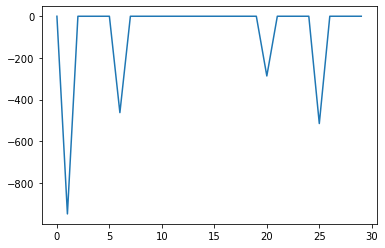

In [161]:
import matplotlib.pyplot as plt
plt.plot(hist.history['r2'])

In [160]:

# 학습결과 확인

results = morpheme_model.evaluate(X_test, y_test)
print('mean_squared_error:',results)

# 학습 결과의 확인
predicts = morpheme_model.predict(X_test)
predicts = np.asarray(predicts)
predicts = [ 1 if x>0.5 else 0 for [x] in predicts]
y = np.asarray(y_test)
y = y.reshape(y.shape[0],)

from sklearn.metrics import classification_report
print(classification_report(y, predicts))

207/207 [==============================] - 2s 10ms/step - loss: 0.2554 - r2: -0.0535
mean_squared_error: [0.2554118037223816, -0.05353507399559021]
              precision    recall  f1-score   support

           0       0.72      0.71      0.72      3308
           1       0.72      0.73      0.72      3310

    accuracy                           0.72      6618
   macro avg       0.72      0.72      0.72      6618
weighted avg       0.72      0.72      0.72      6618



In [162]:
model_json = morpheme_model.to_json()
with open("morpheme_model.json", "w") as json_file:
    json_file.write(model_json)
json_file.close()
print("save network to morpheme_model.json")

morpheme_model.save_weights("morpheme_model.h5")
print("save weights to morpheme_model.h5")

save network to morpheme_model.json
save weights to morpheme_model.h5


In [130]:
def morpheme_discriminator(queries):
    # queries : 복수의 문장의 2차원 배열 (None,1)
    # return : 결과 score 배열 (None,)
    x_codes = []
    for query in queries:
        x_codes.append(morpheme_encode(query))
    scores = morpheme_model.predict(np.array(x_codes))
    return scores #1.0 if scores > 0.5 else 0.0 

In [165]:
morpheme_discriminator([' 무럭무럭 자라서, 아기는 소녀가 예쁘고 마음씨 고운 되었어요'])

array([[0.22752675]], dtype=float32)

In [149]:
org_text = """옛날 어느 집에 귀여운 여자 아기가 태어났어요.
아기는 무럭무럭 자라서, 예쁘고 마음씨 고운 소녀가 되었어요.
그러던 어느날, 소녀의 어머니가 병이들어 그만 세상을 떠나고 말았어요.
소녀의 아버지는 홀로 남은 소녀가 걱정되었어요.
그래서 얼마 후 새어머니를 맞이했어요.
새어머니는 소녀보다 나이가 위인 두 딸을 데리고 왔어요.
그러나 새어머니와 언니들은 성질이 고약한 심술쟁이들이었어요.
새어머니는 소녀가 자기 딸들보다 예쁘고 착한 게 못마땅했어요.
그런데 이번에는 아버지마저 돌아가셨어요.
소녀는 하녀처럼 하루 종일 쓸고, 닦고, 집안일을 도맡아 했어요.
해도 해도 끝이 없는 집안일이 힘들어 지칠때면
난롯가에 앉아서 잠시 쉬곤 했지요.
"엄마, 저애를 신데렐라라고 불러야겠어요."
"온통 재투성이잖아요. 호호호!" 두 언니는 소녀를 놀려 댔어요.
어느 날, 왕궁에서 무도회가 열렸어요.
신데렐라의 집에도 초대장이 왔어요.
새어머니는 언니들을 데리고 무도회장으로 떠났어요.
신데렐라도 무도회에 가고 싶었어요.
혼자 남은 신데렐라는 훌쩍훌쩍 울기 시작했어요.
"신데렐라, 너도 무도회에 가고 싶니?"
신데렐라가 고개를 들어보니, 마법사 할머니가 빙그레 웃고 있었어요.
"내가 너를 무도회에 보내주마 호박 한개와 생쥐 두마리, 도마뱀을 구해 오렴."
마법사 할머니가 주문을 외웠어요.
그리고 지팡이로 호박을 건드리자, 호박이 화려한 황금 마차로 변했어요.
이번에는 생쥐와 도마뱀을 건드렸어요.
그랬더니 생쥐는 흰말로, 도마뱀은 멋진 마부로 변했답니다.
신데렐라의 옷도 구슬 장식이 반짝이는 예쁜 드레스로 바뀌웠어요.
"신데렐라, 발을 내밀어 보거라."
할머니는 신데렐라에게 반짝반짝 빛나는 유리 구두를 신겨 주었어요.
"신데렐라, 밤 열두시가 되면 모든게 처음대로 돌아간단다. 황금 마차는 호박으로, 흰말은 생쥐로, 마부는 도마뱀으로 변하게 돼. 그러니까 반드시 밤 열두 시가 되기 전에 돌아와야 해. 알겠지?"
왕자님도 아름다운 신데렐라에게 마음을 빼았겼어요.
왕자님은 무도회장에 모인 다른 아가씨들은 쳐다보지도 않고,신데렐라하고만 춤을 추었어요.
신데렐라는 왕자님과 춤을 추느라 시간 가는 줄도 몰랐어요.
땡, 땡, 땡...... 벽시계가 열두 시를 알리는 소리에 신데렐라는 화들짝 놀랐어요.
신데렐라가 허둥지둥 왕궁을 빠져나가는데,
유리 구두 한 짝이 벗겨졌어요.
하지만 구두를 주울 틈이 없었어요.
신데렐라를 뛰쫓아오던 왕자님은 층계에서 유리 구두 한 짝을 주웠어요.
왕자님은 유리 구두를 가지고 임금님께 가서 말했어요.
"이 유리 구두의 주인과 결혼하겠어요."
그래서 신하들은 유리 구두의 주인을 찾아 온 나라를 돌아다녔어요.
언니들은 발을 오므려도 보고, 구두를 늘려도 보았지만 한눈에 보기에도 유리 구두는 너무 작았어요.
그때, 신데렐라가 조용히 다가와 말했어요.
"저도 한번 신어 볼 수 있나요?"
신데렐라는 신하게 건넨 유리 구두를 신었어요,
유리 구두는 신데렐라의 발에 꼭 맞았어요.
신하들은 신데렐라를 왕궁으로 데리고 갔어요.
그 뒤 신데렐라는 왕자님과 결혼하여 오래오래 행복하게 살았대요."""

In [150]:
org_text = clean_text(org_text).strip()
org_text

'옛날 어느 집에 귀여운 여자 아기가 태어났어요. 아기는 무럭무럭 자라서 예쁘고 마음씨 고운 소녀가 되었어요. 그러던 어느날 소녀의 어머니가 병이들어 그만 세상을 떠나고 말았어요. 소녀의 아버지는 홀로 남은 소녀가 걱정되었어요. 그래서 얼마 후 새어머니를 맞이했어요. 새어머니는 소녀보다 나이가 위인 두 딸을 데리고 왔어요. 그러나 새어머니와 언니들은 성질이 고약한 심술쟁이들이었어요. 새어머니는 소녀가 자기 딸들보다 예쁘고 착한 게 못마땅했어요. 그런데 이번에는 아버지마저 돌아가셨어요. 소녀는 하녀처럼 하루 종일 쓸고 닦고 집안일을 도맡아 했어요. 해도 해도 끝이 없는 집안일이 힘들어 지칠때면 난롯가에 앉아서 잠시 쉬곤 했지요. 엄마 저애를 신데렐라라고 불러야겠어요. 온통 재투성이잖아요. 호호호! 두 언니는 소녀를 놀려 댔어요. 어느 날 왕궁에서 무도회가 열렸어요. 신데렐라의 집에도 초대장이 왔어요. 새어머니는 언니들을 데리고 무도회장으로 떠났어요. 신데렐라도 무도회에 가고 싶었어요. 혼자 남은 신데렐라는 훌쩍훌쩍 울기 시작했어요. 신데렐라 너도 무도회에 가고 싶니? 신데렐라가 고개를 들어보니 마법사 할머니가 빙그레 웃고 있었어요. 내가 너를 무도회에 보내주마 호박 한개와 생쥐 두마리 도마뱀을 구해 오렴. 마법사 할머니가 주문을 외웠어요. 그리고 지팡이로 호박을 건드리자 호박이 화려한 황금 마차로 변했어요. 이번에는 생쥐와 도마뱀을 건드렸어요. 그랬더니 생쥐는 흰말로 도마뱀은 멋진 마부로 변했답니다. 신데렐라의 옷도 구슬 장식이 반짝이는 예쁜 드레스로 바뀌웠어요. 신데렐라 발을 내밀어 보거라. 할머니는 신데렐라에게 반짝반짝 빛나는 유리 구두를 신겨 주었어요. 신데렐라 밤 열두시가 되면 모든게 처음대로 돌아간단다. 황금 마차는 호박으로 흰말은 생쥐로 마부는 도마뱀으로 변하게 돼. 그러니까 반드시 밤 열두 시가 되기 전에 돌아와야 해. 알겠지? 왕자님도 아름다운 신데렐라에게 마음을 빼았겼어요. 왕자님은 무도회장에 모인 다른 아가씨들은 쳐다보지도 않고신데렐라하고만 춤

In [60]:
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer

if DO_ALL:
    # embedder download...
    embedder = SentenceTransformer('xlm-r-large-en-ko-nli-ststb')

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
100%|██████████| 1.80G/1.80G [01:34<00:00, 18.9MB/s] 


In [146]:
# 생성된 문장의 원문 유사도를 측정하기 위한 함수

import scipy
#print(doc_emb)
def similarity_discriminator(queries,org_embedding):
    # queries : 복수의 문장의 2차원 배열 (None,1)
    # org_embedding : 비교 대상의 원문 embedding 1차원 배열 (1,)
    # return : 결과 score 배열 (None,)
    total_score = 0
    query_embeddings = embedder.encode(queries,show_progress_bar=False)
    for query, query_embedding in zip(queries, query_embeddings):
        distances = scipy.spatial.distance.cdist([query_embedding], [org_embedding], "cosine")[0]
        results = zip(range(len(distances)), distances)
        for idx, distance in results:
            total_score += 1-distance
    return total_score

In [151]:

# 원문의 embedding...
org_text_emb = embedder.encode([org_text],show_progress_bar=False)[0]
org_text_emb

array([ 0.15200937,  0.92120725, -0.17669258, ..., -0.7280674 ,
        0.7422453 , -0.41552892], dtype=float32)

In [152]:
org_term_set = (' ' + org_text + ' ').split(' ')

_MAX_GEN_TOKEN = 40
_NOISE_DIM = len(org_term_set)

word_table = {}

for index, word in zip(range(len(org_term_set)),org_term_set):
    word_table[index] = word
    
print('Token table of origin text')
print('---------------------------------------------')
print(' Code         Token      ')
print('')
for k in word_table.keys():
  print( f'  {str(k).ljust(8)}    {word_table[k]}')
print('---------------------------------------------')

Token table of origin text
---------------------------------------------
 Code         Token      

  0           
  1           옛날
  2           어느
  3           집에
  4           귀여운
  5           여자
  6           아기가
  7           태어났어요.
  8           아기는
  9           무럭무럭
  10          자라서
  11          예쁘고
  12          마음씨
  13          고운
  14          소녀가
  15          되었어요.
  16          그러던
  17          어느날
  18          소녀의
  19          어머니가
  20          병이들어
  21          그만
  22          세상을
  23          떠나고
  24          말았어요.
  25          소녀의
  26          아버지는
  27          홀로
  28          남은
  29          소녀가
  30          걱정되었어요.
  31          그래서
  32          얼마
  33          후
  34          새어머니를
  35          맞이했어요.
  36          새어머니는
  37          소녀보다
  38          나이가
  39          위인
  40          두
  41          딸을
  42          데리고
  43          왔어요.
  44          그러나
  45          새어머니와
  46          언니들은
  47          성질이
  48          고약한
  49     

In [153]:
sota_text = """소녀의 언니들은 심술쟁이들 이었어요. 소녀는 집안일을 도맡아 했어요. 신데렐라도 무도회에 가고 싶었어요. 
마법사 할머니가 주문을 외웠어요. 황금 마차로 드레스로 바뀌웠어요. 밤 열두시가 되면 처음대로 돌아간단다. 
왕자님도 신데렐라에게 마음을 빼았겼어요. 벽시계가 열두 시를 알리는 소리에 놀랐어요. 유리 구두 벗겨졌어요. 
왕자님은 주인을 찾아 돌아다녔어요. 구두는 신데렐라의 발에 맞았어요."""

In [166]:
print('Similarity of sota:',similarity_discriminator([sota_text],org_text_emb))

Similarity of sota: 0.5623787538098033


In [155]:
# Print iterations progress
class ProgressBar:

    def __init__(self,total=20, prefix = '', suffix = '', decimals = 1, length = 20, fill = '|', printEnd = "\r"):
        self.total = total
        self.prefix = prefix
        self.suffix = suffix
        self.decimals = decimals
        self.length = length
        self.fill = fill
        self.printEnd = printEnd
        self.ite = 0

    def printProgress(self,iteration, text):
        self.ite += iteration
        percent = ("{0:." + str(self.decimals) + "f}").format(100 * (self.ite / float(self.total)))

        filledLength = int(self.length * self.ite // self.total)
        bar = self.fill * filledLength + '.' * (self.length - filledLength)
        print(f'\r{self.prefix} |{bar}| {percent}% {self.suffix}  {text}', end="", flush=True)
        # Print New Line on Complete
        if self.ite == self.total: 
            print()

word density scan : |||||||||||||||||||||| 100.0%   filer:[0] 338/339       
story density scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 337/338       
story density scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 336/337       
story density scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2, 3] 335/336       
Negative words: ['여자' '소녀가' '어머니가' '소녀가' '새어머니를' '새어머니는' '딸을' '새어머니는' '못마땅했어요.' '집안일을'
 '엄마' '언니는' '새어머니는' '신데렐라도' '신데렐라가' '할머니가' '무도회에' '할머니가' '흰말로' '신데렐라의'
 '신데렐라' '할머니는' '신데렐라' '흰말은' '전에' '신데렐라에게' '신데렐라는' '몰랐어요.' '벽시계가' '신데렐라가'
 '신데렐라를' '왕자님은' '주인을' '언니들은' '신데렐라가' '신데렐라는' '신데렐라의' '신데렐라를' '신데렐라는']
story density scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 337/338       
story density scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 336/337       
story density scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2, 3] 335/336       


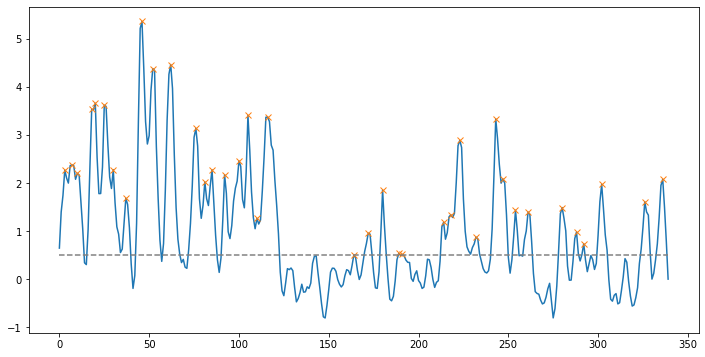

집에 태어났어요. 자라서 소녀의 병이들어 소녀의 걱정되었어요. 소녀보다 언니들은 자기 소녀는 힘들어 쉬곤 신데렐라라고 소녀를 신데렐라의 언니들을 무도회에 훌쩍훌쩍 멋진 예쁜 신데렐라에게 열두시가 모든게 아름다운 왕자님은 쳐다보지도 가는 신데렐라는 허둥지둥 벗겨졌어요. 뛰쫓아오던 결혼하겠어요. 나라를 오므려도 작았어요. 신하들은 오래오래 

Peak count:38   Similarity : 0.7968596135458943


In [158]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram


# weight 들의 초기화
terms = np.array(list(word_table.values()))

story_filters=np.array([[0,1],[0,1,2],[0,1,2,3]]) # ,[0,1,2,3,4],[0,2,4,6]])#,[0,2],[0,2,4],[0,2,4,6],[0,2,4,6,8]])
word_filters=np.array([[0]])

story_weights = np.zeros(_NOISE_DIM,)
word_weights = np.zeros(_NOISE_DIM,)

#filters=np.array([[0,2],[0,2,4],[0,2,4,6],[0,2,4,6,8]])
#filters=np.array([[0,1,2,3,4,5]])
terms = np.array(list(word_table.values()))

# story에 지배적인 word를 찾는다.

# 먼저 word의 강세 분석
for filter in word_filters:
    #print(filter)
    last_idx = len(terms)-(max(filter)+1)
    pb = ProgressBar(last_idx,prefix='word density scan :')
    for conv in range(last_idx):
        pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
        t = np.array(filter) + conv
        w = terms[t][0]
        if w.endswith('.'):
            score = 0.0
        else:
            #part_sen = ' '.join(terms[t]) 
            #score = similarity_discriminator([part_sen],org_text_emb)
            score = similarity_discriminator([w],org_text_emb)
        word_weights[t] += score
        
# story의 강세 분석
for filter in story_filters:
    #print(filter)
    last_idx = len(terms)-(max(filter)+1)
    pb = ProgressBar(last_idx,prefix='story density scan:')
    for conv in range(last_idx):
        pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
        t = np.array(filter) + conv
        part_sen = ' '.join(terms[t]) 
        score = similarity_discriminator([part_sen],org_text_emb)
        story_weights[t] += score

#각각의 peak를 산출
word_peaks, _ = find_peaks(word_weights, height=0)
story_peaks, _ = find_peaks(story_weights, height=0)

#두개의 peak가 겹치는 word에 대해 한개 word가 유사도에 미치는 영향이 큰것으로 간주
#해당 word를 유사도 판단 필터에서 제외하고 다시 필터링...
#이를 통해 story에 대한 word를 최대한 추출 한다.

dup_order = []
for i in range(_NOISE_DIM):
    #lst = ""
    if (i in word_peaks) and (i in story_peaks):
        dup_order.append(i)
# Story에 대한 weight을 추출하기 위해, word에 유독 강세가 있는 term을 제외 시킨다.
print('Negative words:',terms[dup_order])
terms[dup_order] = '---'
'''
print('Token table of origin text')
print('---------------------------------------------')
print(' Code         Token      ')
print('')
for index, word in zip(range(len(terms)),terms):
    print( f'  {str(index).ljust(8)}    {word}')
print('---------------------------------------------')
'''
story_weights = np.zeros(_NOISE_DIM,)
# 그리고 다시 story 분석 스캔
for filter in story_filters:
    #print(filter)
    last_idx = len(terms)-(max(filter)+1)
    pb = ProgressBar(last_idx,prefix='story density scan:')
    for conv in range(last_idx):
        pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
        t = np.array(filter) + conv
        part_sen = ' '.join(terms[t]) 
        part_sen.replace('소녀','---')
        score = similarity_discriminator([part_sen],org_text_emb)
        story_weights[t] += score

# base line
base_line = 0.5
# 다시 peak 추출
story_peaks, _ = find_peaks(story_weights, height=base_line)

# story density 표출
plt.figure(figsize=(12, 6))
plt.plot(story_weights)
plt.plot(story_peaks, story_weights[story_peaks], "x")
plt.plot(np.zeros_like(story_weights)+base_line, "--", color="gray")
plt.show()    

# story skeleton 추출
skel_text = ""
for k in story_peaks:
    #print(k,term_weight[k],word_table[k])
    skel_text += word_table[k]+' '  

print(skel_text)
print('')
print(f'Peak count:{len(story_peaks)}   Similarity : {similarity_discriminator([skel_text],org_text_emb)}')

In [167]:
for index, word in zip(range(len(org_term_set)),org_term_set):
    word_table[index] = word
    
print('Token table of origin text')
print('---------------------------------------------')
print(' Code         Token              Score')
print('')
for k in word_table.keys(): 
  print( f'  {str(k).ljust(8)}    {word_table[k].ljust(10)}    {story_weights[k]}')
print('---------------------------------------------')

Token table of origin text
---------------------------------------------
 Code         Token              Score

  0                         0.6451925679403608
  1           옛날            1.3961949082121148
  2           어느            1.742937409783795
  3           집에            2.269103556240156
  4           귀여운           2.103311448456196
  5           여자            1.9968258203739075
  6           아기가           2.360523803402428
  7           태어났어요.        2.376419896055118
  8           아기는           2.3595265452270127
  9           무럭무럭          2.0760544641121217
  10          자라서           2.2008528989134737
  11          예쁘고           2.1647708496325486
  12          마음씨           1.6008096556427323
  13          고운            1.0442165695373755
  14          소녀가           0.3397408604187009
  15          되었어요.         0.30241050929080493
  16          그러던           1.0338721040527605
  17          어느날           2.3258109920747945
  18          소녀의           3.53242770082635


In [168]:

# text의 생성
def text_gen(noise, term_length):
    gtext = []
    sorted_noise = np.sort(noise)[::-1]
    order = np.where(noise > sorted_noise[term_length+1])[0][-term_length:]
    assert len(order) == term_length
    for k in order:
        gtext.append((word_table[k],k))
        #text += word_table[k]+' '    
    return gtext 

score:[-0.3796988] text:집에 귀여운 태어났어요. 
score:[-0.56331444] text:자라서 어느날 병이들어 말았어요. 
score:[-0.44714892] text:홀로 걱정되었어요. 
score:[0.69060886] text:소녀보다 언니들은 고약한 소녀가 소녀는 했어요. 
score:[0.92563754] text:집안일이 힘들어 온통 신데렐라의 집에도 언니들을 무도회에 싶었어요. 
score:[-0.34961337] text:시작했어요. 
score:[1.0713959] text:신데렐라 마법사 너를 건드리자 화려한 장식이 예쁜 주었어요. 
score:[0.8115722] text:모든게 생쥐로 시가 돌아와야 무도회장에 추었어요. 
score:[-0.34961337] text:시간 몰랐어요. 
score:[0.74621856] text:열두 구두 짝이 뛰쫓아오던 구두를 결혼하겠어요. 
score:[0.08599778] text:나라를 언니들은 작았어요. 
score:[-0.34961337] text:한번 맞았어요. 
score:[0.35186917] text:왕궁으로 오래오래 
Train... |||||................| 20.0%   10/50 epochs, morpheme score:0.17263826727867126 집에 귀여운 태어났어요. 자라서 어느날 병이들어 말았어요. 홀로 걱정되었어요. 소녀보다 언니들은 고약한 소녀가 소녀는 했어요. 집안일이 힘들어 온통 신데렐라의 집에도 언니들을 무도회에 싶었어요. 시작했어요. 신데렐라 마법사 너를 건드리자 화려한 장식이 예쁜 주었어요. 모든게 생쥐로 시가 돌아와야 무도회장에 추었어요. 시간 몰랐어요. 열두 구두 짝이 뛰쫓아오던 구두를 결혼하겠어요. 나라를 언니들은 작았어요. 한번 맞았어요. 왕궁으로 오래오래                                            score:[-0.34961337] text:여자 태어났어요. 
score:[0

score:[-0.04979095] text:열두시가 모든게 시가 돌아와야 아름다운 왕자님은 쳐다보지도 신데렐라는 가는 신데렐라는 구두 왕자님은 구두를 임금님께 신하들은 나라를 신데렐라가 조용히 신하들은 오래오래 
score:[0.61406046] text:자라서 소녀의 병이들어 소녀의 걱정되었어요. 
score:[0.48289242] text:소녀보다 두 언니들은 고약한 자기 소녀는 힘들어 쉬곤 신데렐라라고 두 언니는 소녀를 열렸어요. 
score:[0.5117354] text:신데렐라의 언니들을 무도회에 가고 훌쩍훌쩍 무도회에 들어보니 마법사 할머니가 그리고 황금 멋진 마부로 예쁜 신데렐라에게 열두시가 모든게 밤 시가 전에 아름다운 쳐다보지도 추었어요. 
score:[-0.27765217] text:가는 열두 신데렐라는 허둥지둥 벗겨졌어요. 
score:[-0.23466638] text:뛰쫓아오던 구두의 결혼하겠어요. 
score:[-0.07730635] text:구두의 나라를 신하들은 오래오래 
score:[-0.10251248] text:태어났어요. 
score:[0.505756] text:자라서 예쁘고 소녀의 병이들어 세상을 떠나고 소녀의 걱정되었어요. 
score:[0.96303076] text:새어머니를 소녀보다 언니들은 자기 소녀는 하녀처럼 힘들어 쉬곤 신데렐라라고 온통 소녀를 신데렐라의 언니들을 무도회에 훌쩍훌쩍 무도회에 가고 들어보니 마법사 건드렸어요. 
score:[1.3162764] text:멋진 마부로 장식이 예쁜 할머니는 신겨 주었어요. 
score:[1.1363375] text:열두시가 모든게 돌아와야 아름다운 왕자님은 쳐다보지도 가는 줄도 신데렐라는 허둥지둥 벗겨졌어요. 
score:[-0.34961337] text:결혼하겠어요. 
score:[-0.06794839] text:나라를 오므려도 작았어요. 
score:[0.48624426] text:신하들은 오래오래 
Train... |||||||||||||........| 60.0%

score:[-0.30216098] text:뛰쫓아오던 결혼하겠어요. 
score:[-0.0350939] text:나라를 꼭 신하들은 오래오래 
score:[-0.7175948] text:집에 태어났어요. 
score:[0.61406046] text:자라서 소녀의 병이들어 소녀의 걱정되었어요. 
score:[0.9249879] text:후 소녀보다 위인 언니들은 고약한 소녀가 자기 게 돌아가셨어요. 
score:[0.16506] text:소녀는 하루 쓸고 힘들어 쉬곤 신데렐라라고 소녀를 신데렐라의 집에도 언니들을 무도회에 가고 싶었어요. 
score:[0.72637993] text:훌쩍훌쩍 울기 들어보니 구해 그랬더니 멋진 예쁜 신데렐라에게 열두시가 모든게 시가 아름다운 왕자님은 쳐다보지도 신데렐라는 가는 신데렐라는 유리 벗겨졌어요. 
score:[0.39957753] text:하지만 뛰쫓아오던 신하들은 오므려도 신하들은 
score:[0.12064611] text:소녀의 병이들어 소녀의 걱정되었어요. 
score:[1.2017679] text:소녀보다 언니들은 고약한 소녀가 자기 소녀는 힘들어 쉬곤 신데렐라라고 온통 두 소녀를 신데렐라의 언니들을 떠났어요. 
score:[1.2595878] text:무도회에 가고 훌쩍훌쩍 가고 들어보니 마법사 할머니가 주문을 건드렸어요. 
score:[0.29176265] text:멋진 마부로 예쁜 신데렐라에게 구두를 열두시가 모든게 그러니까 아름다운 신데렐라에게 마음을 왕자님은 쳐다보지도 않고신데렐라하고만 가는 신데렐라는 화들짝 허둥지둥 벗겨졌어요. 
score:[-0.14792743] text:구두의 나라를 구두는 수 데리고 오래오래 
score:[0.67585707] text:자라서 소녀의 병이들어 세상을 떠나고 소녀의 걱정되었어요. 
score:[1.0671554] text:소녀보다 언니들은 소녀가 자기 소녀는 하녀처럼 쓸고 힘들어 쉬곤 신데렐라라고 언니는 소녀를 신데렐라의 언니들을 무도회에 훌쩍훌쩍 너를 한개와 화려

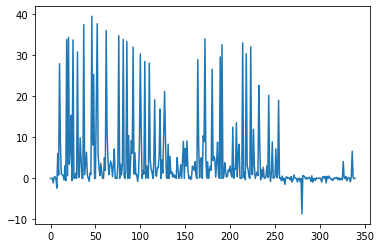

result text :  예쁘고 소녀의 병이들어 떠나고 소녀의 걱정되었어요. 후 소녀보다 언니들은 고약한 소녀가 자기 소녀는 하녀처럼 힘들어 쉬곤 신데렐라라고 온통 두 소녀를 열렸어요. 신데렐라의 집에도 언니들을 무도회에 훌쩍훌쩍 가고 들어보니 마법사 할머니가 있었어요. 지팡이로 화려한 멋진 장식이 반짝이는 예쁜 신데렐라에게 주었어요. 열두시가 모든게 그러니까 시가 돌아와야 아름다운 왕자님은 쳐다보지도 추었어요. 가는 줄도 신데렐라는 허둥지둥 벗겨졌어요.
result score :  0.7622917585046112
skel_text :  집에 태어났어요. 자라서 소녀의 병이들어 소녀의 걱정되었어요. 소녀보다 언니들은 자기 소녀는 힘들어 쉬곤 신데렐라라고 소녀를 신데렐라의 언니들을 무도회에 훌쩍훌쩍 멋진 예쁜 신데렐라에게 열두시가 모든게 아름다운 왕자님은 쳐다보지도 가는 신데렐라는 허둥지둥 벗겨졌어요. 뛰쫓아오던 결혼하겠어요. 나라를 오므려도 작았어요. 신하들은 오래오래 


In [169]:
term_weight = np.zeros(_NOISE_DIM,)

p_score = 0
scale = 10
epochs = 50
sum_length = len(story_peaks) + int(len(story_peaks)*0.4)
pb = ProgressBar(epochs/scale,prefix='Train...')
count = 1
for epoch in range(epochs):
    noise = np.random.rand(_NOISE_DIM,)
    # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
    noise[story_peaks] += np.mean(noise)
    noise += term_weight / count
    gtext = text_gen(noise,sum_length)
    #print(' '.join([w for (w,k) in gtext]))
    #print([k for (w,k) in gtext])    
    # 문장 단위로 잘라서 문법 체크...
    total_score = []
    tw = ""
    tk = []
    for (w,k) in gtext:
        tw += w + ' '
        tk.append(k)
        if w.endswith('.'):
            # morpheme_discriminator
            #print(tk)
            score = morpheme_discriminator([tw])[0]
            print(f'score:{score} text:{tw}')
            term_weight[tk] += score
            total_score.append(score)
            tw = ""
            tk = []
            
    if len(tk) > 0:
        # morpheme_discriminator
        #print(tw)
        #print(tk)        
        score = morpheme_discriminator([tw])[0]
        print(f'score:{score} text:{tw}')
        term_weight[tk] += score
        total_score.append(score)
        tw = ""
        tk = []        
            
    #term_weight[order] += score
    '''
    reward = p_score - score
    if (p_score ==0):
        pass
    else:
        term_weight[order] += reward
    p_score = score
    '''
    text = ' '.join([w for (w,k) in gtext])
    count += 1
    if epoch%scale == 0:
        pb.printProgress(+1,f'{epoch+scale}/{epochs} epochs, morpheme score:{np.mean(total_score)} {text}                                            ')

        
#plt.plot(term_weight)
plt.plot(term_weight)
plt.show()
gtext = text_gen(term_weight,sum_length)
text = ' '.join([w for (w,k) in gtext])
score = similarity_discriminator([text],org_text_emb)
print('result text : ',text)
print('result score : ',score)
print('skel_text : ',skel_text)